In [7]:
#Librerias
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from scipy import ndimage as ndi
from PIL import Image
import os, glob

In [2]:
#Utilidades punto 1

def Fourier_transform(f, y, t):
    f = np.asarray(f)
    y = np.asarray(y)
    t = np.asarray(t)
    M = len(f)
    F = np.zeros(M, dtype=complex)
    dt = t[1] - t[0]
    for i in range(M):
        F[i] = np.sum(y * np.exp(-2j * np.pi * f[i] * t)) * dt
    return F

def generate_data(tmax,dt,A,freq,noise):
    
    ts = np.arange(0,tmax+dt,dt)
    return ts, np.random.normal(loc=A*np.sin(2*np.pi*ts*freq),scale=noise)

def Eliminate_max(datos, margen):
    datos = np.array(datos)
    margen = int(margen)   
    idx_max = np.argmax(datos)  
    inicio = max(0, idx_max - margen)
    fin = min(len(datos), idx_max + margen + 1)
    datos_filtrados = np.delete(datos, np.arange(inicio, fin))
    return datos_filtrados

def fwhm(x, y):
    x = np.array(x)
    y = np.array(y)
    i_max = np.argmax(y)
    y_max = y[i_max]
    if y_max <= 0:
        return np.nan
    half = y_max / 2.0
    # izquierda
    iL = np.where(y[:i_max] <= half)[0]
    if len(iL) == 0:
        return np.nan
    i1 = iL[-1]
    i2 = i1 + 1
    t = (half - y[i1]) / (y[i2] - y[i1] + 1e-12)
    x_left = x[i1] + t * (x[i2] - x[i1])
    # derecha
    iR = np.where(y[i_max:] <= half)[0]
    if len(iR) == 0:
        return np.nan
    i1 = iR[0] + i_max
    i0 = i1 - 1
    t = (half - y[i0]) / (y[i1] - y[i0] + 1e-12)
    x_right = x[i0] + t * (x[i1] - x[i0])

    # ancho
    width = x_right - x_left
    return width

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


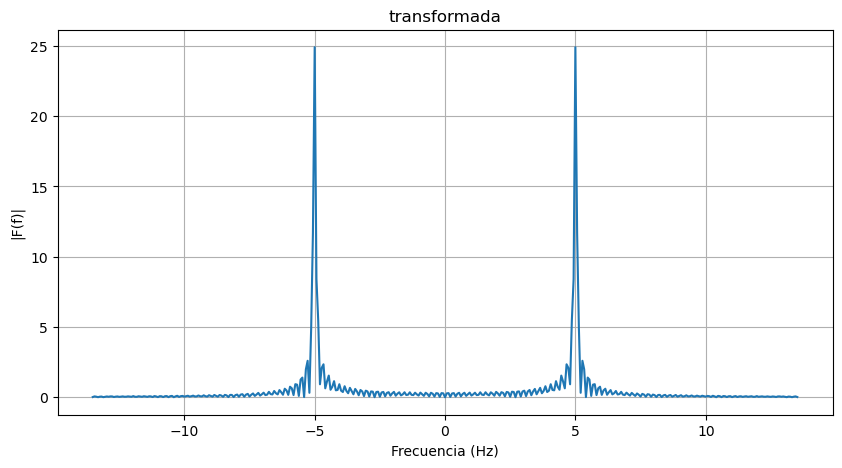

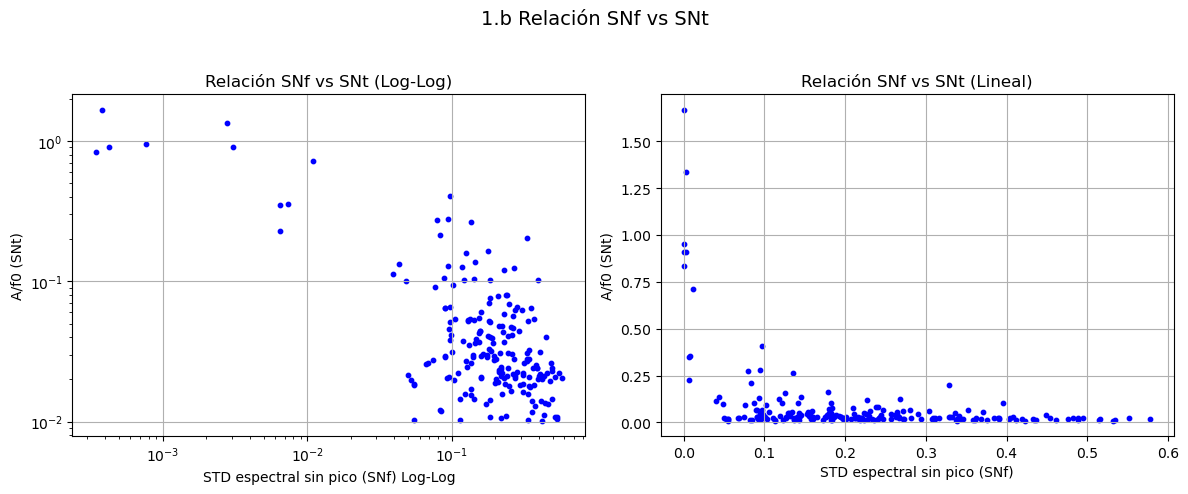

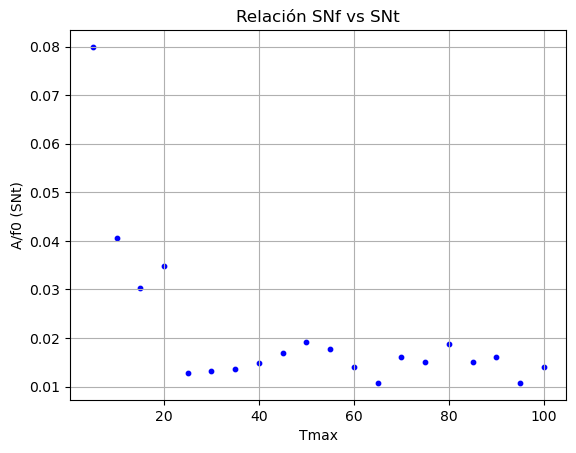

In [3]:
#Punto 1
#a
f0 = 5  # Hz
t, r = generate_data(10, 0.001, 5, f0, 0.1)
f_vec = np.linspace(-f0*2.7,f0*2.7, 401)  
T_F = Fourier_transform(f_vec, r, t)

plt.figure(figsize=(10,5))
plt.plot(f_vec, np.abs(T_F))
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("|F(f)|")
plt.title("transformada")
plt.grid(True)
plt.savefig("1.a.pdf", dpi=300, bbox_inches="tight")

#b
LisSNt=[]
LisSNf=[]
for i in range(0,201):
    f0=np.random.randint(10,1000)/100
    A=np.random.randint(1,3)/10
    noise=np.random.randint(10,500)/100
    a=f0*1.5
    t, r=generate_data(a,0.001,A,f0,noise)
    f_vec = np.linspace(0,a, 401)
    F=Fourier_transform(f_vec, r, t)
    SNt=A/f0
    SNf_i=Eliminate_max(F,1.2/a)
    SNf=float(np.std(SNf_i))
    LisSNt.append(SNt)   
    LisSNf.append(SNf)   

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(LisSNf, LisSNt, s=10, c="blue", marker="o")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("STD espectral sin pico (SNf) Log-Log")
plt.ylabel("A/f0 (SNt)")
plt.title("Relación SNf vs SNt (Log-Log)")
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(LisSNf, LisSNt, s=10, c="blue", marker="o")
plt.xlabel("STD espectral sin pico (SNf)")
plt.ylabel("A/f0 (SNt)")
plt.title("Relación SNf vs SNt (Lineal)")
plt.grid(True)

plt.suptitle("1.b Relación SNf vs SNt", fontsize=14)  
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.savefig("1.b.pdf", dpi=300, bbox_inches="tight")

#c
LisAp=[]
LisTmax=[]
for i in range(1,21):
    f0=5
    A=5
    tmax=f0*1*i
    t, r=generate_data(tmax,0.001,A,f0,0.1)
    f_vec = np.linspace(0,f0*1.5, 401)
    F=Fourier_transform(f_vec, r, t)
    Ap=fwhm(f_vec,F)
    LisAp.append(Ap)
    LisTmax.append(tmax)

    
plt.figure()
plt.scatter(LisTmax, LisAp, s=10, c="blue", marker="o")  
plt.xlabel("Tmax")
plt.ylabel("A/f0 (SNt)")
plt.title("Relación SNf vs SNt")
plt.grid(True)
plt.savefig("1.c.pdf", dpi=300, bbox_inches="tight")




In [4]:
#Utilidades 2
def EPPS0(x, y):

    x = np.array(x)
    y = np.array(y)

    fft_vals = np.fft.fft(y)
    fft_freqs = np.fft.fftfreq(len(x), d=(x[1] - x[0]))  


    positive_freqs = fft_freqs[:len(fft_freqs)//2]
    magnitudes = np.abs(fft_vals[:len(fft_vals)//2])

    peaks, _ = find_peaks(magnitudes)

    if len(peaks) == 0:
        return None 

    
    return positive_freqs[peaks[1]]

def max_loc(arr):
    indices=[] 
    
    for i in range(1, len(arr)-1):
        if arr[i-1] < arr[i] and arr[i] > arr[i+1]:   
                               
            indices.append(i)
    return indices 

def FPB (x):
    y=x+(10*np.cos(x))
    return y


In [5]:
#2
#a
Datos = "SN_d_tot_V2.0.csv"

array_datos = []
with open(Datos, newline='', encoding='utf-8') as archivo:
    lector = csv.reader(archivo)
    for fila in lector:
        array_datos.append(fila)
         
del array_datos[0]
lisv=[]
for i in range(len(array_datos)):
    for j in  range(len(array_datos[i])):
        a=float(array_datos[i][j])
        array_datos[i][j] = a
    if array_datos[i][4] == -1.0:
        lisv.append(i)

Datc = [elem for i, elem in enumerate(array_datos) if i not in lisv]

lisf=[]
liss=[]
for i in range(len(Datc)):
    lisf.append(Datc[i][3]-1818)
    liss.append(abs(Datc[i][4]))
    
x = np.array(lisf)
y = np.array(liss)

f_interp = interp1d(x, y, kind='cubic')
x_new = np.linspace(x.min(), x.max(), len(array_datos))
y_new = abs(f_interp(x_new))


plt.figure()
plt.plot(x_new, y_new, label="Interpolación cúbica")
plt.legend()
plt.savefig("2.a.pdf", dpi=300, bbox_inches="tight")
plt.close()

#2
f = EPPS0(x_new, y_new)
P = 1/f


np.savetxt("P.txt", np.atleast_1d(P))


y_cop=[]
for i in range(0,len(x_new)):
    fil=FPB(x_new[i])
    if y_new[i] < fil:
       y_cop.append(y_new[i])
    else:
        y_cop.append(0)
y_copu=np.array(y_cop)


fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(x_new, y_new, 'b')
axs[0].set_title("Normal")

axs[1].plot(x_new, y_copu, 'r')
axs[1].set_title("Con filtro")

plt.tight_layout()
plt.savefig("2.b.data.pdf", dpi=300, bbox_inches="tight")
plt.close()


maxi = max_loc(y_copu)

fechas=[]
som=[]
for i in range(len(x_new)):
    if i in maxi:
        fechas.append(x_new[i])
        som.append(y_copu[i])
Fa=np.array(fechas)
Sa=np.array(som)

plt.figure()
plt.plot(Fa, Sa, label="Interpolación cúbica")
plt.legend()
plt.savefig("2.b.maxima.pdf", dpi=300, bbox_inches="tight")
plt.close()


FileNotFoundError: [Errno 2] No such file or directory: 'SN_d_tot_V2.0.csv'

In [5]:
#Utilidades 3

# 3.a: blur gaussiano en frecuencia 
def fft2_gaussian_blur_rgb(img_rgb: np.ndarray, sigma_frac: float = 0.06) -> np.ndarray:
    """
    Aplica desenfoque gaussiano multiplicando la FFT2 por una gaussiana 2D en frecuencia.
    img_rgb: uint8 (H,W,3).  sigma_frac ~ 0.04–0.10 (fracción de tamaño de imagen).
    Retorna float en [0,1].
    """
    img = img_rgb.astype(float) / 255.0
    H, W, _ = img.shape
    cy, cx = H // 2, W // 2
    yy, xx = np.ogrid[:H, :W]
    r2 = (yy - cy) ** 2 + (xx - cx) ** 2
    sigma = sigma_frac * max(H, W)
    G = np.exp(-r2 / (2.0 * sigma**2))  # filtro pasa-bajas suave

    out = np.empty_like(img)
    for c in range(3):
        F = np.fft.fftshift(np.fft.fft2(img[..., c]))
        Ff = F * G
        out[..., c] = np.real(np.fft.ifft2(np.fft.ifftshift(Ff)))
    out = np.clip(out, 0, 1)
    return out

#3.b: eliminación de ruido periódico por “notches”
def _notch_zero(F, y, x, hw):
    """Pone a cero un rectángulo centrado en (y,x) de semiancho hw, recortando bordes."""
    H, W = F.shape
    y1, y2 = max(0, y - hw), min(H, y + hw + 1)
    x1, x2 = max(0, x - hw), min(W, x + hw + 1)
    F[y1:y2, x1:x2] = 0

def remove_periodic_noise(gray: np.ndarray, k_peaks: int = 14,
                          r0: int = 8, notch_hw: int = 4, tau: float = 6.0) -> np.ndarray:
    """
    Quita ruido periódico anulando picos brillantes del espectro (fftshift) fuera del DC.
    - k_peaks: máximos a intentar anular (se hace simétricamente).
    - r0: radio del disco central que se ignora (DC y muy bajas f).
    - notch_hw: semiancho del “notch” (tamaño ~ (2*hw+1)^2).
    - tau: umbral relativo (pico > tau * mediana de magnitudes restantes).
    Retorna float en [0,1].
    """
    img = gray.astype(float) / 255.0
    H, W = img.shape
    cy, cx = H // 2, W // 2

    F = np.fft.fftshift(np.fft.fft2(img))
    Mag = np.abs(F)

    yy, xx = np.ogrid[:H, :W]
    r = np.sqrt((yy - cy) ** 2 + (xx - cx) ** 2)
    band = (r > r0) & (r < 0.49 * min(H, W))  # no tocar DC ni el borde extremo
    work = Mag.copy()
    work[~band] = 0

    Fclean = F.copy()
    for _ in range(k_peaks):
        i = int(np.argmax(work))
        val = float(work.flat[i])
        if val <= 0:
            break
        med = np.median(work[work > 0])
        if med <= 0 or val < tau * med:
            break
        y, x = np.unravel_index(i, work.shape)

        # Notch en el pico y en su simétrico (asegura salida real)
        _notch_zero(Fclean, y, x, notch_hw)
        ys, xs = 2 * cy - y, 2 * cx - x
        _notch_zero(Fclean, ys, xs, notch_hw)

        # Evitar elegir los mismos píxeles otra vez
        _notch_zero(work, y, x, notch_hw)
        _notch_zero(work, ys, xs, notch_hw)

    clean = np.real(np.fft.ifft2(np.fft.ifftshift(Fclean)))
    # Normalización robusta a [0,1]
    vmin, vmax = np.percentile(clean, [0.5, 99.5])
    clean = np.clip((clean - vmin) / (vmax - vmin + 1e-12), 0, 1)
    return clean

# helpers de IO
def load_rgb(path: str) -> np.ndarray:
    return np.array(Image.open(path).convert("RGB"))

def load_gray(path: str) -> np.ndarray:
    return np.array(Image.open(path).convert("L"))

def save_u8(img01: np.ndarray, path: str):
    Image.fromarray((np.clip(img01, 0, 1) * 255).astype(np.uint8)).save(path)


In [6]:
# 3
# 3.a — Desenfoque (Miette)
miette_path = "miette.jpg"     # usa tu ruta si difiere
img_rgb = load_rgb(miette_path)
blur = fft2_gaussian_blur_rgb(img_rgb, sigma_frac=0.06)  # ajusta 0.04–0.10 si quieres más/menos blur
save_u8(blur, "3.a.jpg")
print("Guardado 3.a.jpg")

# 3.b.a — Ruido periódico (p_a_t_o)
pato_path = "p_a_t_o.jpg"      # usa tu ruta si difiere
pato_gray = load_gray(pato_path)
pato_clean = remove_periodic_noise(pato_gray, k_peaks=18, r0=10, notch_hw=5, tau=6.0)
save_u8(pato_clean, "3.b.a.jpg")
print("Guardado 3.b.a.jpg")

# 3.b.b — G_a_t_o (si no existe, usa miette como fallback)
candidates = []
for ext in ("png", "jpg", "jpeg"):
    candidates += glob.glob(f"g_a_t_o.{ext}")
gato_src = candidates[0] if candidates else miette_path  # fallback
gato_gray = load_gray(gato_src)
gato_clean = remove_periodic_noise(gato_gray, k_peaks=18, r0=10, notch_hw=5, tau=6.0)
save_u8(gato_clean, "3.b.b.png")
print(f"Guardado 3.b.b.png (fuente: {gato_src})")


Guardado 3.a.jpg
Guardado 3.b.a.jpg
Guardado 3.b.b.png (fuente: g_a_t_o.png)


Frecuencia encontrada: 1.256500 ciclos/día
Periodo estimado: 0.795861 días


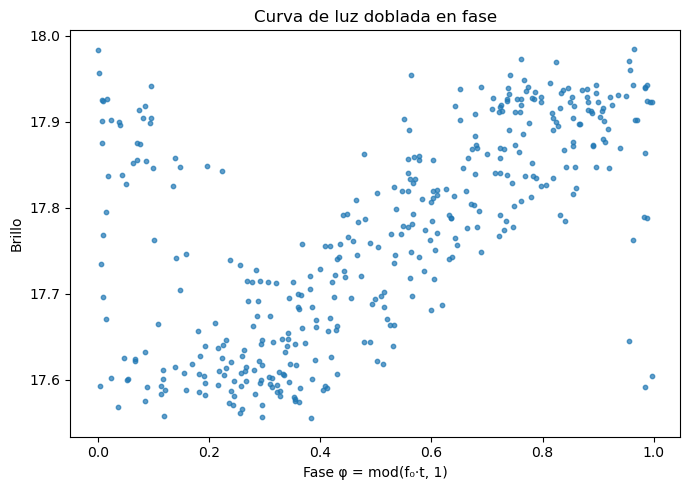

In [62]:
#4

datos = np.loadtxt("OGLE-LMC-CEP-0001.dat")
t = datos[:, 0]       
y = datos[:, 1]        

baseline = t.max() - t.min()
df = 1.0 / baseline / 5.0
freqs = np.arange(0.01, 2.0, df)

power = []
for f in freqs:
    c = np.cos(2*np.pi*f*t)
    s = np.sin(2*np.pi*f*t)
    X = np.column_stack([c, s])
    coef, _, _, _ = np.linalg.lstsq(X, y - y.mean(), rcond=None)
    A, B = coef
    power.append(0.5*(A*A + B*B))

power = np.array(power)
f0 = freqs[np.argmax(power)]   
print(f"Frecuencia encontrada: {f0:.6f} ciclos/día")
print(f"Periodo estimado: {1/f0:.6f} días")


phi = np.mod(f0 * t, 1.0)


plt.figure(figsize=(7,5))
plt.scatter(phi, y, s=10, alpha=0.7)
plt.xlabel("Fase φ = mod(f₀·t, 1)")
plt.ylabel("Brillo")
plt.title("Curva de luz doblada en fase")
plt.tight_layout()
plt.savefig("4.pdf", bbox_inches="tight")
plt.show()


In [ ]:
#Utilidades 5

def ram_lak_filter(n: int) -> np.ndarray:
    """
    Filtro pasa-altas tipo Ram–Lak (rampa) para rFFT de longitud n.
    Se normaliza a 1 en Nyquist y se apodiza suavemente con Hann.
    """
    freqs = np.fft.rfftfreq(n)                 # [0, 0.5]
    H = np.abs(freqs)
    H /= (H.max() + 1e-12)
    if H.size > 1:
        hann = 0.5 - 0.5*np.cos(2*np.pi*np.arange(H.size)/(H.size-1))
        H *= hann
    return H

def filter_projection(signal_1d: np.ndarray) -> np.ndarray:
    """Aplica Ram–Lak en frecuencia a una proyección 1D."""
    s = np.asarray(signal_1d, dtype=float)
    n = s.size
    S = np.fft.rfft(s, n=n)
    H = ram_lak_filter(n)
    return np.fft.irfft(S * H, n=n)

def filtered_backprojection(sinogram: np.ndarray,
                            angles_degrees: np.ndarray | None = None,
                            rows: int | None = None,
                            normalize: bool = True) -> np.ndarray:
    """
    Reconstrucción por backprojection filtrada.
    """
    S = np.asarray(sinogram, dtype=float)
    # Esperado: filas = ángulos, columnas = detectores. Si no, transpone.
    if S.shape[0] < S.shape[1]:
        S = S.T
    n_angles, n_det = S.shape

    if angles_degrees is None:
        angles = np.linspace(0.0, 180.0, n_angles, endpoint=False)
    else:
        angles = np.asarray(angles_degrees)
        if angles.size != n_angles:
            raise ValueError("angles_degrees debe tener n_ángulos elementos.")

    # MUY IMPORTANTE para que el snippet funcione sin redimensionar:
    # el ancho de salida debe coincidir con n_det.
    if rows is None:
        rows = int(n_det)

    recon = np.zeros((rows, rows), dtype=float)

    for k, ang in enumerate(angles):
        # 1) proyección 1D y filtrado pasa-altas
        proj = S[k, :]
        signal = filter_projection(proj)   # ← señal filtrada

        rotation_angle = ang
        imagen_rotada = ndi.rotate(
            np.tile(signal[:, None], rows).T,  # (rows, n_det)
            rotation_angle,
            reshape=False,
            mode="reflect"
        )

        # 3) Acumular
        recon += imagen_rotada

    if normalize:
        vmin, vmax = float(recon.min()), float(recon.max())
        if vmax > vmin:
            recon = (recon - vmin) / (vmax - vmin)
        else:
            recon[:] = 0.0
    return recon


In [8]:
# 5
sinogram_path = "1.npy"   # ajusta si tu archivo está en otra ruta
output_path   = "4.png"

# 1) Cargar sinograma
S = np.load(sinogram_path)
print("Forma del sinograma (cargado):", S.shape)

# 2) Forzar orientación esperada: filas=ángulos, columnas=detectores
Sin = S if S.shape[0] >= S.shape[1] else S.T
print("Forma usada para reconstrucción:", Sin.shape, "(filas=ángulos, cols=detectores)")

# 3) Reconstrucción FBP con parámetros conservadores (recuperar visibilidad)
#    - Filtro: Ram-Lak puro (pasa-altas) SIN cutoff
#    - Sin pre-blur
#    - Rotación bilineal (order=1)
#    - SIN máscara circular
#    - SIN auto-orientación (ya orientamos arriba)

recon = filtered_backprojection(Sin, angles_degrees=None, rows=Sin.shape[1], normalize=True)

# 4) Guardar PNG (normalizado en la función)
img_u8 = (np.clip(recon, 0, 1) * 255).astype(np.uint8)
Image.fromarray(img_u8).save(output_path)
print(f"forma: {recon.shape}  |  min/max: {recon.min():.3f}/{recon.max():.3f}")

# 5) Visualización con estiramiento de contraste (solo para pantalla)
p1, p99 = np.percentile(recon, [1, 99])
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

im0 = ax[0].imshow(Sin, aspect="auto", cmap="gray")
ax[0].set_title("Sínograma (orientado)")
ax[0].set_xlabel("Detectores")
ax[0].set_ylabel("Ángulos")
plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(recon, cmap="gray", vmin=p1, vmax=p99)
ax[1].set_title("Reconstrucción (FBP)")
ax[1].axis("off")
plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '1.npy'